# Roman WFI Synthetic Photometry with synphot

***

## Kernel Information

To run this notebook, please select the "Roman Calibration" kernel at the top right of your window.

This notebook is read-only. You can run cells and make edits, but you must save changes to a different location. We recommend saving the notebook within your home directory, or to a new folder within your home (e.g. <span style="font-variant:small-caps;">file > save notebook as > my-nbs/nb.ipynb</span>). Note that a directory must exist before you attempt to add a notebook to it.

## Introduction

**Purpose**:<br>
In this tutorial, we will demonstrate how to use the Synthetic Photometry (`synphot`) and Synthetic Photometry for HST (`stsynphot`) software to estimate the brightness of both empirical and theoretical sources as they would be measured by the Roman Wide Field Instrument (WFI). Note that we will use terms such as transmission and throughput interchangeably throughout the tutorial, but what we mean is the unitless measurement efficiency as a function of wavelength (or frequency) for the detection of photons at the end of the optics chain between the Roman primary mirror and the WFI detectors including all components in between (e.g., secondary mirror, optical elements, etc.). For more information on `synphot` and `stsynphot` and its use with Roman data, please visit the [RDox pages on synphot](https://roman-docs.stsci.edu/simulation-tools-handbook-home/simulation-development-utilities/synphot-for-roman).

***

## Reference Data

The cell below will check to ensure ancillary reference files for `synphot` and `stpsf` packages are installed. If not, it will download the ancillary reference files and install them under your home directory (i.e., `${HOME}/refdata/`).

### Local Run Settings

If you want to run the notebook in your local machine, refer to the information in the [local installation](../../markdown/local-run.md) instructions before proceeding with the notebook. The instructions provide important information about setting up your environment, installing dependnecies, and adding to your working directory scripts to help with the reference data installation.

Depending on which (if any) reference data are missing, this cell may take several minutes to execute.

### On the Roman Research Nexus

If you are working on the Nexus, then the ancillary reference data are pre-installed and this cell will execute instantly.

In [1]:
import os
import sys
import importlib.util

import notebook_data_dependencies as ndd

# Download reference data (if necessary)
result = ndd.install_files(packages=['synphot', 'stpsf'])
ndd.setup_env(result)


Found stpsf path /home/runner/refdata/stpsf-data
Found synphot path /home/runner/refdata/grp/redcat/trds/
Reference data paths set to:
	STPSF_PATH = /home/runner/refdata/stpsf-data
	PYSYN_CDBS = /home/runner/refdata/grp/redcat/trds/


## Loading data

Models, simulations, and instrument's data used in this notebook are loaded from Flexible Image Transport System (FITS) binary tables using functions within `stsynphot` and the simulated point spread functions pacakge for NASA's James Webb Space Telescope (JWST) and Nancy Grace Roman Space Telescope `stpsf`. For more information on the software and its use with Roman data, please visit the [RDox pages on STPSF](https://roman-docs.stsci.edu/simulation-tools-handbook-home/stpsf-for-roman).

On the Roman Research Nexus the ancillary reference data are pre-installed. If running localy the data will be downloaded in the Reference Data Installation section. Data may also be loaded as NumPy NDArray objects. Note that Roman WFI throughput information in `stsynphot` and `stpsf` produce identical results. JWST instrument throughputs are currently only available via stpsf.

**IMPORTANT NOTE:** Roman WFI throughputs from `stsynphot` and `stpsf` are currently for a single detector and combine the entire optical chain. Updates to the transmission information are expected as part of the ground testing campaign of both the WFI and the integrated observatory and eventually on-orbit commissioning. Newer throughput curves per detector (including, e.g., variations in average detector quantum efficiency) are available at the [Roman Technical Information Repository](https://github.com/RomanSpaceTelescope/roman-technical-information/), and will be made available in the future using WFI calibration reference files. Simulations using [Roman I-Sim](../romanisim/romanisim.ipynb) use zeropoints per detector derived from the throughput curves in the technical information repository. You can use the throughput curves from the repository in the examples below by reading in the file and creating a `synphot.SpectralElement` object with an `astropy.models.Empirical1D` model.

## Imports
- *os* for access to environment variables and file paths (previous cell)
- *astropy.units* for unit specification and conversion
- *matplotlib.pyplot* for plotting
- *numpy* for data array creation and manipulation
- *synphot* for synthetic photometry
- *stsynphot* for access to HST, Roman, and other transmission curves
- *stpsf* for access to Roman and JWST transmission curves (optional)

In [2]:
%matplotlib inline

from astropy import units as u
import matplotlib.pyplot as plt
import numpy as np

import synphot as syn
import stsynphot as stsyn
import stpsf

### Sample Run

Let's pretend we have a very simple bandpass that only has three samples in wavelength:
```
wavelength = [1, 1.1., 1.2] microns
throughput = [0.0, 0.75, 0.0]
```
We can create our `synphot.SpectralElement` object as follows:

In [3]:
# Set up the bandpass information
wavelength = np.array([1, 1.1, 1.2]) * u.micron
throughput = np.array([0, 0.75, 0])

# Create the bandass as a synphot.SpectralElement object
bandpass = syn.SpectralElement(syn.models.Empirical1D, points=wavelength, lookup_table=throughput)

# Evaluate the bandpass at 1.05 micron
bandpass(1.05 * u.micron)

<Quantity 0.375>

It is important to note that the curves in the Roman Technical Information Repository are **effective area** curves rather than unitless throughput. The only modification required to use effective area curves in the examples below is to set the collecting area of the telescope to 1 m<sup>2</sup> in any function that requires the collecting area (e.g., when computing instrumental count rate).

## Use Cases and Examples

### Plot the Roman WFI Filter Throughputs and Information

There are two approaches to retrieving WFI throughput information. Here we will show both methods of loading the throughput information. All the remaining steps in the tutorial are independent from the specific loading method.

#### Retrieving WFI Throughputs from STPSF

To retrieve the optical element throughput information from `stpsf`, we set up the WFI object, and use the method `_get_synphot_bandpass`, which takes the optical element name as the only argument. In the example below, we load the throughput information for the F129 imaging filter. This new Python object behaves as a callable function that takes as input the wavelength or frequency of interest and returns the throughput at that wavelength or frequency.

In [4]:
# Set up the Roman WFI object and retrieve the throughput of a filter
roman = stpsf.WFI()
wfi_f129 = roman._get_synphot_bandpass('F129')
print(wfi_f129(1.29 * u.micron))

0.6693794055442986


#### Retrieving WFI Throughputs from stsynphot

If we want to retrieve the same information using `stsynphot`, which contains tools to load STScI-specific bandpass information from the Spectral Atlas Files for Synphot Software, we use the `synphot.band` class and give as input a string that contains the mission, instrument, and element name, e.g., "roman, wfi, f129":

In [5]:
# Set up the Roman WFI object and retrieve the throughput of a filter
wfi_f129 = stsyn.band('roman, wfi, f129')
print(wfi_f129(1.29 * u.micron))

0.6448


#### Plotting and Computing Bandpass Information

Regardless of the method we chose to load the throughput data, we can then plot the throughput curves and compute some information about our bandpasses. The following code block will generate a plot of the WFI imaging filter throughputs (with the exception of the wide F146 filter, which has been omitted for clarity):

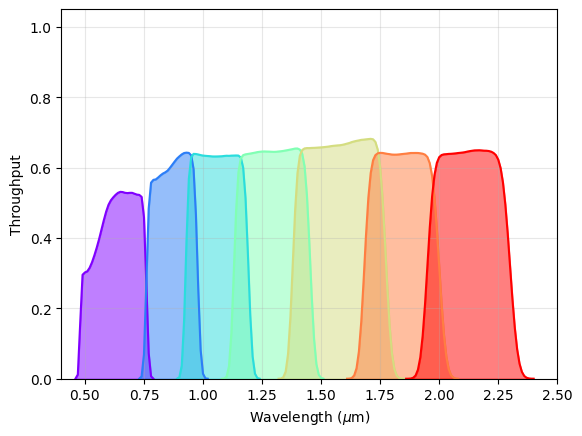

In [6]:
# Set up the Roman WFI object and make a list of the optical element names
roman_filter = 'F062 F087 F106 F129 F158 F184 F213'.lower().split()
 
# Set up wavelengths from 0.4 to 2.5 microns in increments of 0.01 microns.
waves = np.arange(0.4, 2.5, 0.01) * u.micron
 
# Set up figure
fig, ax = plt.subplots()
 
# For each optical element, plot the throughput in a different color
# and shade the area below the curve.
colors = plt.cm.rainbow(np.linspace(0, 1, len(roman_filter)))
for i, f in enumerate(roman_filter):
    band = stsyn.band(f'roman,wfi,{f}')
    clean = np.where(band(waves) > 0)
    ax.plot(waves[clean], band(waves[clean]), color=colors[i])
    ax.fill_between(waves[clean].value, band(waves[clean]).value, alpha=0.5, color=colors[i])
 
# Set plot axis labels, ranges, and add grid lines
ax.set_xlabel(r'Wavelength ($\mu$m)')
ax.set_ylabel('Throughput')
ax.set_ylim(0, 1.05)
ax.set_xlim(0.4, 2.5)
ax.grid(':', alpha=0.3)

We can also get information about the bandpasses using the following methods on the bandpass objects in synphot:

In [7]:
band = stsyn.band('roman, wfi, f129')
print('WFI F129:')
print(f'\tBandwidth: {band.photbw():.5f}')
print(f'\tPivot wavelength: {band.pivot():.5f}')
print(f'\tFWHM: {band.fwhm():.5f}')

WFI F129:
	Bandwidth: 942.49697 Angstrom
	Pivot wavelength: 12901.34508 Angstrom
	FWHM: 2219.41077 Angstrom


### Synthetic Photometry of a Simulated Source

Here we show how to perform synthetic photometry of a simulated source. For this example, we will use a star of spectral type M5III, and we will add additional extinction to the source spectrum using the Milky Way extinction law. We also normalize the spectrum to a particular Johnson V-band AB magnitude, but this could be normalized to any flux density or equivalent in any band (e.g., Hubble and JWST instruments, 2MASS, etc.).

In our example, we will use a Phoenix model (Allard et al. 2009, 2007, 2012) for our star with an effective temperature of 3400 Kelvin, specific gravity of log(g)=1.5, and a metallicity of \[M/H\] = -0.5. We use the `grid_to_spec()` function to retrieve the correct model for these input parameters. The `grid_to_spec()` function supports the Kurucz (1993), Castelli & Kurucz (2004), and Phoenix models. For more information, see the [Catalogs and Spectral Atlases](https://stsynphot.readthedocs.io/en/latest/stsynphot/appendixa.html) appendix in the `stsynphot` documentation.

Text(0.5, 0, 'Wavelength ($\\mu$m)')

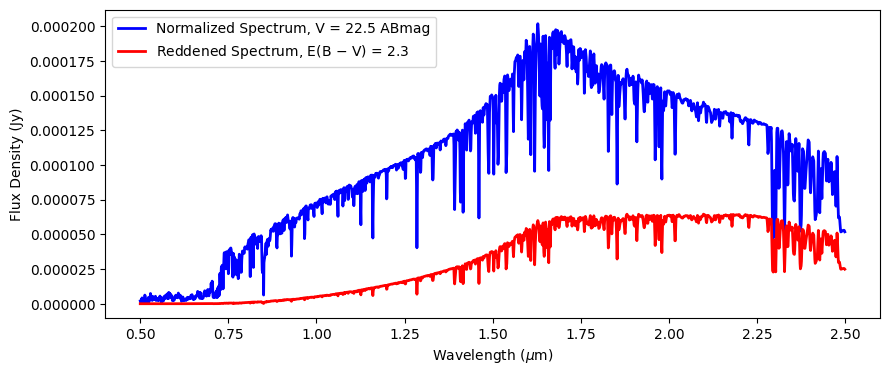

In [8]:
# Retrieve the spectrum of the star
star_spec = stsyn.grid_to_spec('phoenix', 3400, -0.5, 1.5)

# Renormalize the spectrum to have a Johnson V-band magnitude of 22.5 ABmag
norm_spec = star_spec.normalize(22.5 * u.ABmag, band=stsyn.band('johnson, v'))
 
# Add extinction corresponding to E(B-V) = 2.3 using the Milky Way extinction law (Rv = 3.1)
extinction = syn.ReddeningLaw.from_extinction_model('mwavg').extinction_curve(2.3)
final_spec = norm_spec * extinction
 
# Compute the flux density arrays
wavelengths = np.arange(0.5, 2.5, 0.001) * u.micron
norm_fluxes = norm_spec(wavelengths, flux_unit=u.Jy)
final_fluxes = final_spec(wavelengths, flux_unit=u.Jy)
 
# Plot the spectra
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(wavelengths, norm_fluxes, color='blue', lw=2, label='Normalized Spectrum, V = 22.5 ABmag')
ax.plot(wavelengths, final_fluxes, color='red', lw=2, label=r'Reddened Spectrum, E(B $-$ V) = 2.3')
ax.legend(loc=2)
ax.set_ylabel('Flux Density (Jy)')
ax.set_xlabel(r'Wavelength ($\mu$m)')

Now that we have our spectrum, we can "observe" it using the WFI:

In [9]:
# Load the WFI F158 element
wfi_f158 = stsyn.band('roman, wfi, f158')

# Observe the spectrum with the F158 bandpass
obs_spec = syn.Observation(final_spec, wfi_f158)
 
# Print out the magnitudes, flux density, and count rate (electrons per second) of the observed source
print('M5III star, WFI F158:')
print(f'\t{obs_spec.effstim(syn.units.VEGAMAG, vegaspec=syn.SourceSpectrum.from_file(syn.conf.vega_file))}')
print(f'\t{obs_spec.effstim(u.ABmag)}')
print(f'\t{obs_spec.effstim(u.Jy)}')
print(f'\t{obs_spec.countrate(area=np.pi * (2.4 * u.m)**2)}')

M5III star, WFI F158:
	18.511898427421443 mag(VEGA)
	19.816370694994315 mag(AB)
	4.299834322103441e-05 Jy
	1964.8644086735662 ct / s


Now, let's suppose that we wish to estimate the brightness of a source with a spectral energy distribution that can be described with a power law with spectral index of $\alpha=-1$. We have access to a library of Astropy models that can be used to approximate the input spectrum. We will normalize our example to a flux density of 5 mJy at 1.5 $\mu m$.

In [10]:
# Create spectrum model
source = syn.SourceSpectrum(syn.models.PowerLawFlux1D(5 * u.mJy, 1.5 * u.micron, -1))

Now, let's plot the spectrum and make sure that it looks correct:

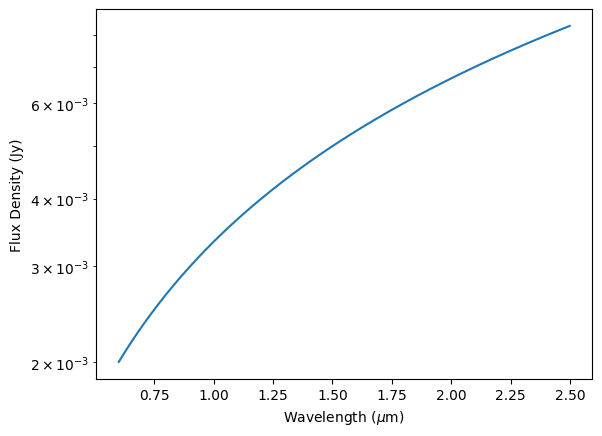

In [11]:
# Create a wavelength array from 0.6 to 2.5 microns in bins of 0.001 micron.
waves = np.arange(0.6, 2.5, 0.001) * u.micron

# Plot the model
fig, ax = plt.subplots()
ax.plot(waves, source(waves, flux_unit=u.Jy))
ax.set_ylabel('Flux Density (Jy)')
ax.set_xlabel(r'Wavelength ($\mu$m)')
ax.set_yscale('log')

Let's add another component to our spectrum to see how models can be combined. In this case, let's add a Gaussian absorption line at 1.2 $\mu m$ with an amplitude of 2 mJy and a full-width half-maximum (FWHM) of 0.1 $\mu m$, and a Gaussian emission line at 1.5 $\mu m$ with an amplitude of 1 mJy and a FWHM of 0.01 $\mu m$.

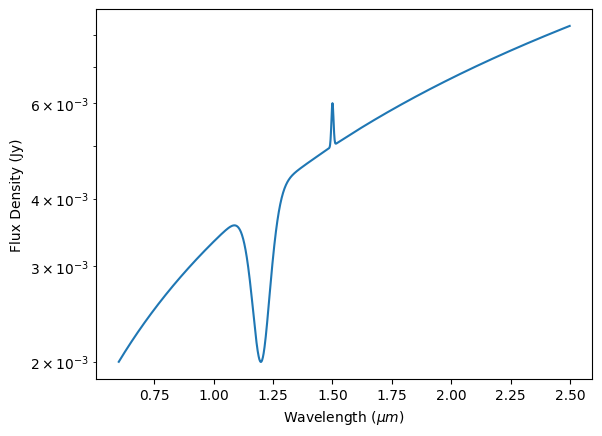

In [12]:
# Create Gaussian emission lines
abs_line = syn.SourceSpectrum(syn.models.GaussianFlux1D, amplitude=2 * u.mJy, mean=1.2 * u.micron, fwhm=0.1 * u.micron)
em_line = syn.SourceSpectrum(syn.models.GaussianFlux1D, amplitude=1 * u.mJy, mean=1.5 * u.micron, fwhm=0.01 * u.micron)

# Add components together and plot the total model
total = source - abs_line + em_line
fig, ax = plt.subplots()
ax.plot(waves, total(waves, flux_unit=u.Jy))
ax.set_xlabel(r'Wavelength ($\mu m$)')
ax.set_ylabel('Flux Density (Jy)')
ax.set_yscale('log')

Let's observe this model spectrum and take a look at what it looks like after it passes through the optical chain by convolving the model with one of our transmission curves:

Text(0, 0.5, 'Observed Flux Density (Jy)')

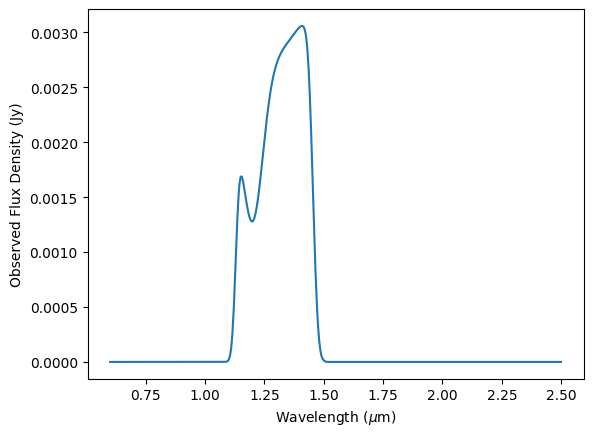

In [13]:
f129 = stsyn.band('roman,wfi,f129')
obs_model = syn.Observation(total, f129)

# Add components together and plot the total model
fig, ax = plt.subplots()
ax.plot(waves, obs_model(waves, flux_unit=u.Jy))
ax.set_xlabel(r'Wavelength ($\mu$m)')
ax.set_ylabel('Observed Flux Density (Jy)')

With our observation object, we can get the integrated flux just as we did before:

In [14]:
print(f'{obs_model.effstim(u.Jy)}')

0.0036306919199092583 Jy


## Additional Resources

- [synphot API documentation](https://synphot.readthedocs.io/en/latest/)
- [stsynphot API documentation](https://stsynphot.readthedocs.io/en/latest/)
- [Reference Atlases](https://archive.stsci.edu/hlsp/reference-atlases)
- [RDox Synphot for Roman Article](https://roman-docs.stsci.edu/simulation-tools-handbook-home/simulation-development-utilities/synphot-for-roman)

***

## About this Notebook

**Author:** Tyler Desjardins and Rosa Diaz<br>
**Updated On:** 2025-10-29

<table width="100%" style="border:none; border-collapse:collapse;">
  <tr style="border:none;">
    <td style="border:none; width:180px; white-space:nowrap;">
       <a href="#top" style="text-decoration:none; color:#0066cc;">↑ Top of page</a> 
    </td>
    <td style="border:none; text-align:center;">
       <img src="../../roman_logo.png" width="50">
    </td>
    <td style="border:none; text-align:right;">
       <img src="../../stsci_logo2.png" width="90">
    </td>
  </tr>
</table>> 